In [1]:
import meep as mp
import numpy as np
import cmath
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
NRES  = 8 # points per wvl/nmax
nslab = 1.4
theta = np.radians(0)

wvl   = 1.0
dpad  = 1.0 * wvl
dslab = dpad
dpml  = 1.0 * wvl

sx = wvl
sy = 2*dpml + dpad + dslab

tol = 1e-8 # default = 1e-8
L   = 10    # default = 2

In [3]:
cell_size  = mp.Vector3(sx,sy,0)
pml_layers = [mp.PML(dpml, direction=mp.Y)]
nonpmlvol  = mp.Volume(center=mp.Vector3(), size=mp.Vector3(wvl, sy-2*dpml))

resolution = NRES/wvl/nslab
print("resolution = %.2f" % resolution)
print("step size = %.2f um" % (1/resolution))
print(NRES,"points per λmin/nmax")

# geometry
geometry = [mp.Block(size=mp.Vector3(sx, dslab+dpml),
                     center=mp.Vector3(y=-(dslab+dpml)/2),
                     material=mp.Medium(index=nslab))]

# src/monitor locations
srcLocation    = mp.Vector3(y=0.5*sy-dpml)
refMonLocation = mp.Vector3(y=0.5*sy-dpml-1/resolution)
trnMonLocation = mp.Vector3(y=-0.5*sy+dpml+1/resolution)
refl_fr        = mp.FluxRegion(center=refMonLocation, size=mp.Vector3(sx))
tran_fr        = mp.FluxRegion(center=trnMonLocation, size=mp.Vector3(sx))

# k_point
def pw_amp(k,x0):
    def _pw_amp(x):
        return cmath.exp(1j*2*np.pi*k.dot(x+x0))
    return _pw_amp
k = mp.Vector3(np.sin(theta), np.cos(theta), 0).scale(1/wvl)
if theta == 0:
    k = mp.Vector3(0,0,0)

# sources
sources = [mp.Source(mp.ContinuousSource(wavelength=wvl),
                     component=mp.Ex,
                     center=srcLocation,
                     size=mp.Vector3(sx),
                     amp_func=pw_amp(k, srcLocation))]

resolution = 5.71
step size = 0.17 um
8 points per λmin/nmax


     block, center = (0,-1,0)
          size (1,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)


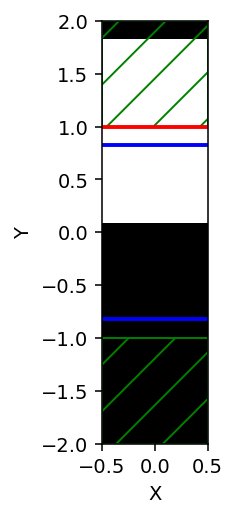

In [4]:
# visualize 2D
def vis2D():
    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k,
                        resolution=resolution,
                        force_complex_fields=True,
                        boundary_layers=pml_layers)
    refl = sim.add_flux(1/wvl, 0, 1, refl_fr)
    tran = sim.add_flux(1/wvl, 0, 1, tran_fr)
    fig  = plt.figure(dpi=140)
    sim.plot2D()
vis2D()

-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 2D dimensions.
Computational cell is 1.05 x 4.025 x 0 with resolution 5.71429
     block, center = (0,-1,0)
          size (1,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
time for set_epsilon = 0.000497103 s
-----------
Meep: using complex fields.
final residual = 5.99222e-09
Finished solve_cw after 82 CG iters (~ 1640 timesteps).
final residual = 1.45405e-10
Finished solve_cw after 93 CG iters (~ 1860 timesteps).
final residual = 7.44959e-11
Finished solve_cw after 99 CG iters (~ 1980 timesteps).
final residual = 7.7394e-12
Finished solve_cw after 106 CG iters (~ 2120 timesteps).
final residual = 9.82631e-13
Finished solve_cw after 107 CG iters (~ 2140 timesteps).


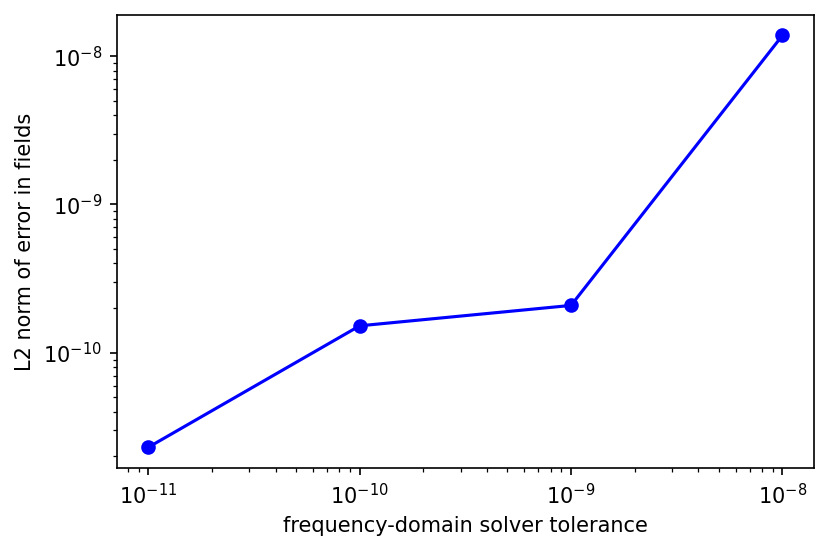

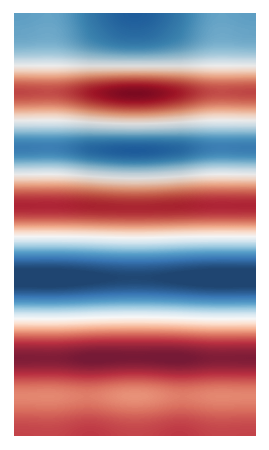

PASSED solve_cw test: error in the fields is decreasing with increasing resolution


In [5]:
# Check for error minimization as tolerance decreases
def check_tol():
    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k,
                        resolution=resolution,
                        force_complex_fields=True,
                        boundary_layers=pml_layers)
    
    # get nonpmlvol size
    sim.init_sim()
    temp = sim.get_array(vol=nonpmlvol, component=mp.Dielectric)
    nx,ny = np.shape(temp)

    num_tols = 5
    tols     = np.power(10, np.arange(-8.0,-8.0-num_tols,-1.0))
    ex_dat   = np.zeros((nx, ny, num_tols), dtype=np.complex_)

    maxiters = 1e4
    L        = 10
    for i in range(num_tols):
        sim.init_sim()
        sim.solve_cw(tols[i], int(maxiters), int(L))
        ex_dat[:,:,i] = sim.get_array(vol=nonpmlvol, component=mp.Ex)

    err_dat = np.zeros(num_tols-1)
    for i in range(num_tols-1):
        err_dat[i] = LA.norm(ex_dat[:,:,i]-ex_dat[:,:,num_tols-1])

    plt.figure(dpi=150)
    plt.loglog(tols[:num_tols-1], err_dat, 'bo-');
    plt.xlabel("frequency-domain solver tolerance");
    plt.ylabel("L2 norm of error in fields");
    plt.show()

    eps_data = sim.get_array(vol=nonpmlvol, component=mp.Dielectric)
    ex_data = np.real(ex_dat[:,:,num_tols-1])

    plt.figure(dpi=140)
    plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
    plt.imshow(ex_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
    plt.axis('off')
    plt.show()

    if np.all(np.diff(err_dat) < 0):
        print("PASSED solve_cw test: error in the fields is decreasing with increasing resolution")
    else:
        print("FAILED solve_cw test: error in the fields is NOT decreasing with increasing resolution")
check_tol()

In [6]:
# normalization run
sim = mp.Simulation(cell_size=cell_size,
                    # geometry=geometry,
                    sources=sources,
                    k_point=k,
                    resolution=resolution,
                    force_complex_fields=True,
                    boundary_layers=pml_layers)
refl = sim.add_flux(1/wvl, 0, 1, refl_fr)
tran = sim.add_flux(1/wvl, 0, 1, tran_fr)

sim.init_sim()
sim.solve_cw(tol=tol, L=int(L))

empty_data = sim.get_flux_data(refl)
empty_flux = mp.get_fluxes(refl)

# geometry run
sim.reset_meep()
sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k,
                    resolution=resolution,
                    force_complex_fields=True,
                    boundary_layers=pml_layers)
refl = sim.add_flux(1/wvl, 0, 1, refl_fr)
tran = sim.add_flux(1/wvl, 0, 1, tran_fr)

sim.load_minus_flux_data(refl, empty_data)
sim.init_sim()
sim.solve_cw(tol=tol, L=int(L))

refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)
freqs = mp.get_flux_freqs(tran)

# Record R/T
R = -np.asarray(refl_flux[0]) / np.asarray(empty_flux[0])
T = np.asarray(tran_flux[0]) / np.asarray(empty_flux[0])

# Fresnel
n1 = 1.0
n2 = nslab
R_Fresnel = np.abs((n1*np.cos(theta)-n2*np.cos(theta))/(n1*np.cos(theta)+n2*np.cos(theta)))**2

-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 2D dimensions.
Computational cell is 1.05 x 4.025 x 0 with resolution 5.71429
time for set_epsilon = 0.000309944 s
-----------
Meep: using complex fields.
final residual = 8.97892e-09
Finished solve_cw after 81 CG iters (~ 1620 timesteps).


-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 2D dimensions.
Computational cell is 1.05 x 4.025 x 0 with resolution 5.71429
     block, center = (0,-1,0)
          size (1,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
time for set_epsilon = 0.000494957 s
-----------
Meep: using complex fields.
final residual = 5.99222e-09
Finished solve_cw after 82 CG iters (~ 1640 timesteps).


In [7]:
# Print output
print("Reflection (Meep):    %.2f" % R)
print("Reflection (Fresnel): %.2f" % R_Fresnel)
print("Transmission (Meep):  %.2f" % T)

Reflection (Meep):    0.01
Reflection (Fresnel): 0.03
Transmission (Meep):  1.26
